In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from pandas import DataFrame
from mpl_toolkits.mplot3d import Axes3D
import os

import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10

from Funciones import *

In [2]:
ruta_base  = os.path.dirname(os.path.abspath('./')) + '/'
ruta_datos = ruta_base + 'Datos/'
ruta_shp   = ruta_datos+ 'Shapefiles/'
ruta_imagenes = ruta_base + 'Imagenes/'

In [3]:
# Carga información y elimina datos nans

datos_pcs = pd.read_csv(ruta_datos+'Datos_PCS.csv', index_col=0, parse_dates=True)

In [4]:
# pcs utilizadas
pcs_util =  ['PC1', 'PC2', 'PC18', 'PC9', 'PC6', 'PC16', 'PC7', 'PC8', 'Caudal']

datos_pcs = datos_pcs[pcs_util]

### Definición de variables independientes y dependiente

In [5]:
X = datos_pcs.drop(['Caudal'],axis=1)
y = datos_pcs['Caudal']

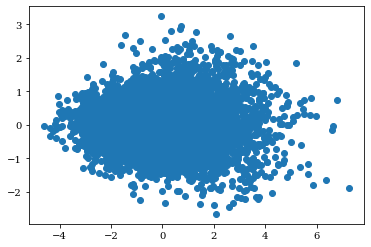

In [6]:
plt.scatter(X['PC1'],X['PC16'])

### Cluster con kmeans

In [7]:
km = KMeans(n_clusters=3)
model=km.fit(X)
y_kmeans=model.fit_predict(X)
print(y_kmeans)

[2 2 2 ... 1 1 1]


In [8]:
centroids = model.cluster_centers_
print(centroids)
print('número de datos asignados a cada centroide:')
print(np.bincount(y_kmeans))

[[-1.32272634  0.59264322 -0.00916409  0.0070835  -0.04274318  0.01295969
  -0.0312124  -0.0181761 ]
 [ 1.83512439  0.63815352  0.05731147  0.05430974  0.03479527  0.01859324
   0.01167013  0.01736602]
 [ 0.06677502 -1.17834302 -0.03460833 -0.05079451  0.02142891 -0.02941509
   0.02645184  0.00709165]]
número de datos asignados a cada centroide:
[2530 1744 2223]


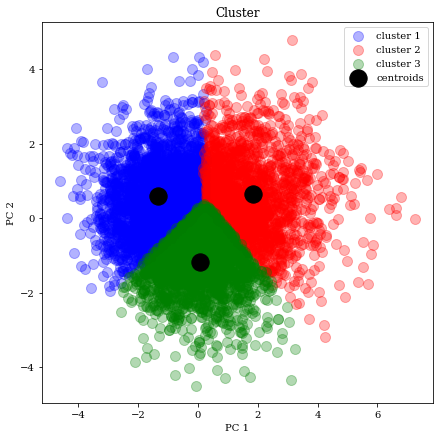

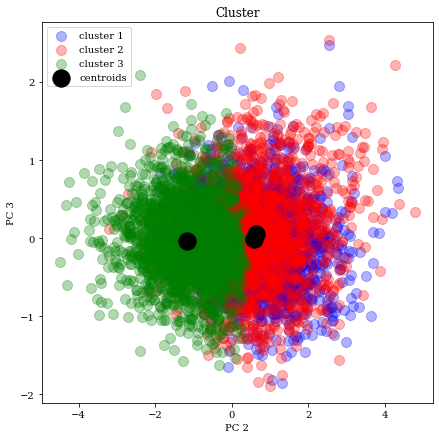

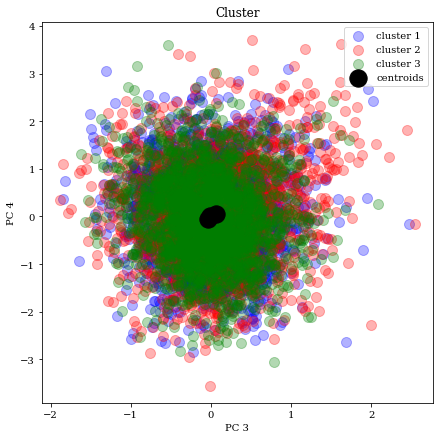

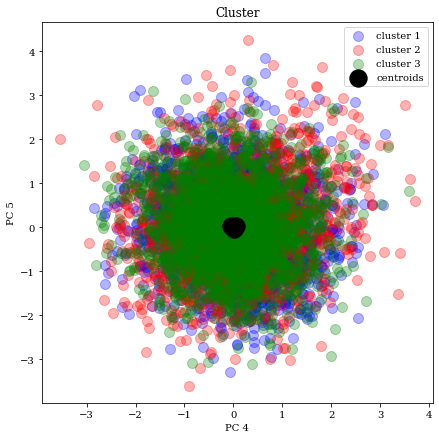

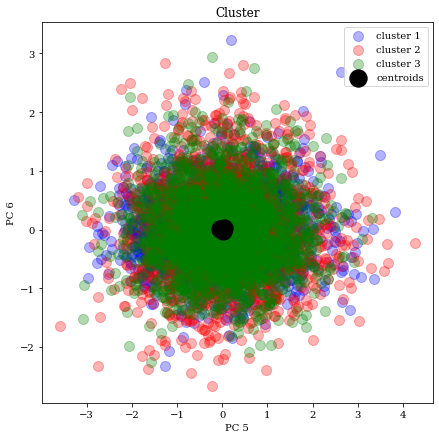

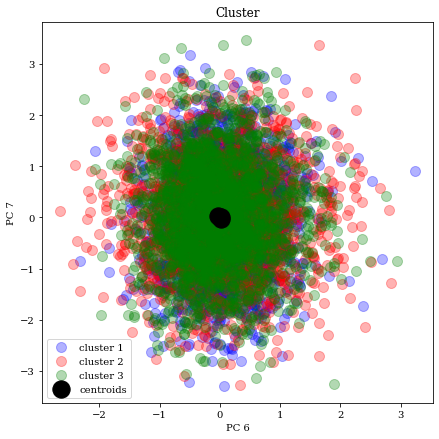

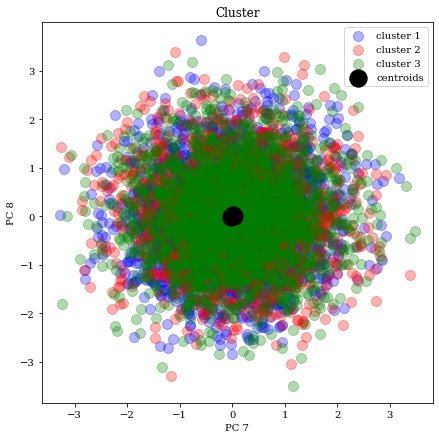

In [9]:
X=np.array(X)
alpha = 0.3

for i in range(X.shape[1]-1):
    
    plt.figure(figsize=(7,7))
    
    pcs =[i,i+1]
    plt.scatter(X[y_kmeans==0,pcs[0]],X[y_kmeans==0,pcs[1]],s=100,c='blue',label='cluster 1', alpha=alpha)
    plt.scatter(X[y_kmeans==1,pcs[0]],X[y_kmeans==1,pcs[1]],s=100,c='red',label='cluster 2', alpha=alpha)
    plt.scatter(X[y_kmeans==2,pcs[0]],X[y_kmeans==2,pcs[1]],s=100,c='green',label='cluster 3', alpha=alpha)
    #plt.scatter(X[y_kmeans==3,0],X[y_kmeans==3,1],s=100,c='yellow',label='cluster 4')
    plt.scatter(model.cluster_centers_[:,pcs[0]],model.cluster_centers_[:,pcs[1]],s=300,c='black', label='centroids')
    plt.title('Cluster')
    plt.xlabel(f'PC {i+1}')
    plt.ylabel(f'PC {i+2}')
    plt.legend();
    if i in [0,1,2]:
        plt.savefig(ruta_imagenes+f'Cluster_kmeans_{i}.png', bbox_inches='tight', dpi=150)

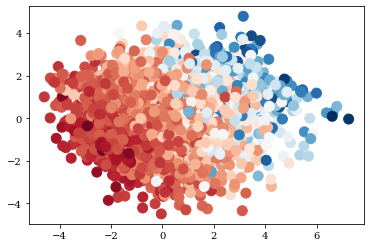

In [10]:
plt.scatter(X[:,0],X[:,1], c=y,s=100, cmap=cm.RdBu)

### Hierarchical clustering

In [11]:
from scipy.spatial import distance_matrix

dd2=pd.DataFrame(distance_matrix(X,X,p=2)) #distancia Euclidiana

In [12]:
from scipy.cluster.hierarchy import dendrogram,linkage
Z=linkage(X,method='ward',metric='euclidean') # matriz Z con todos los enlaces creados

In [13]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
C, coph_dist=cophenet(Z,pdist(X)) # Coeficiente de Cophenet
C

0.3731814440300508

### dendograma

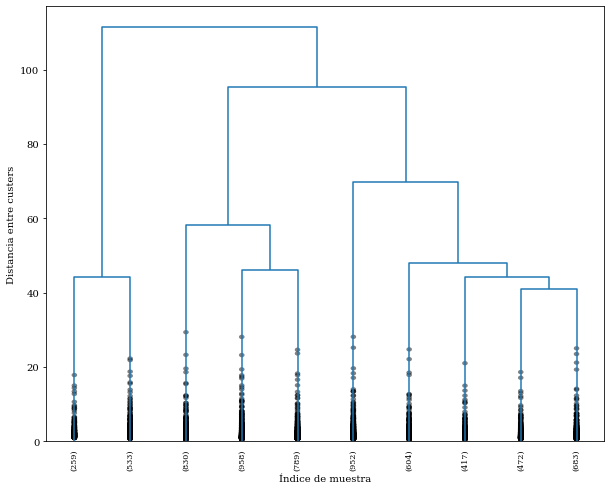

In [14]:
plt.figure(figsize=(10,8))
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia entre custers');
dendrogram(Z,leaf_rotation=90.,leaf_font_size=8,color_threshold=0.2*83,truncate_mode='lastp',p=10,show_leaf_counts=True,show_contracted=True)
plt.savefig(ruta_imagenes+'dendograma.png', bbox_inches='tight', dpi=150)

### Numero de cluster optimo

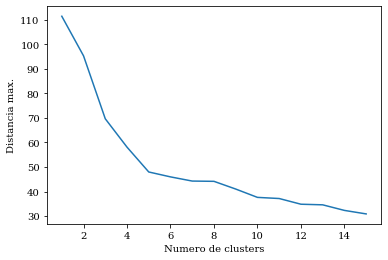

In [15]:
last=Z[-15:,2]
last_rev=last[::-1] #e voltean
idx=np.arange(1,len(last)+1)
plt.plot(idx,last_rev)
plt.xlabel('Numero de clusters')
plt.ylabel('Distancia max.');
plt.savefig(ruta_imagenes+'Cluster_optimo1.png', bbox_inches='tight', dpi=150)

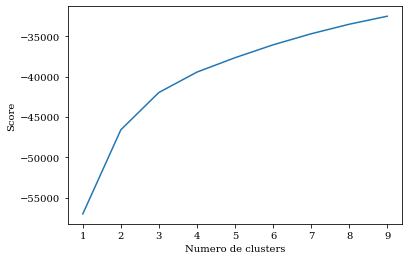

In [16]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
# plt.title('Elbow Curve');
plt.savefig(ruta_imagenes+'Cluster_optimo2.png', bbox_inches='tight', dpi=150)

Los cluster serían 2 o 3, que podrían ser valores negativos, positivos y hasta neutros

In [17]:
# from yellowbrick.cluster import KElbowVisualizer
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# visualizer = KElbowVisualizer(KMeans(), k=(2,7),ax=ax)
# visualizer.fit(X)

# ax.set_xticks(range(2,7))
# visualizer.show()
# plt.show()

### Silhuette

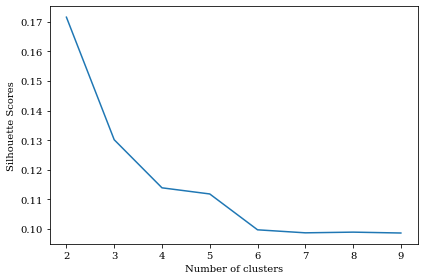

In [18]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='auto')
    km.fit(X)
    silhouette_scores.append(silhouette_score(X, km.labels_))

fig, ax = plt.subplots()
ax.plot(range(2, 10), silhouette_scores)
# ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 10))
plt.tight_layout()
plt.savefig(ruta_imagenes+'Cluster_sil.png', bbox_inches='tight', dpi=150)

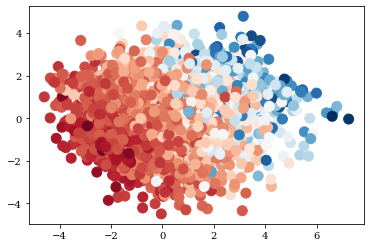

In [19]:
plt.scatter(X[:,0],X[:,1], c=y,s=100, cmap=cm.RdBu)

For n_clusters = 2 The average silhouette_score is : 0.17178578641721162
For n_clusters = 3 The average silhouette_score is : 0.13026060430166292
For n_clusters = 4 The average silhouette_score is : 0.11337680298623684


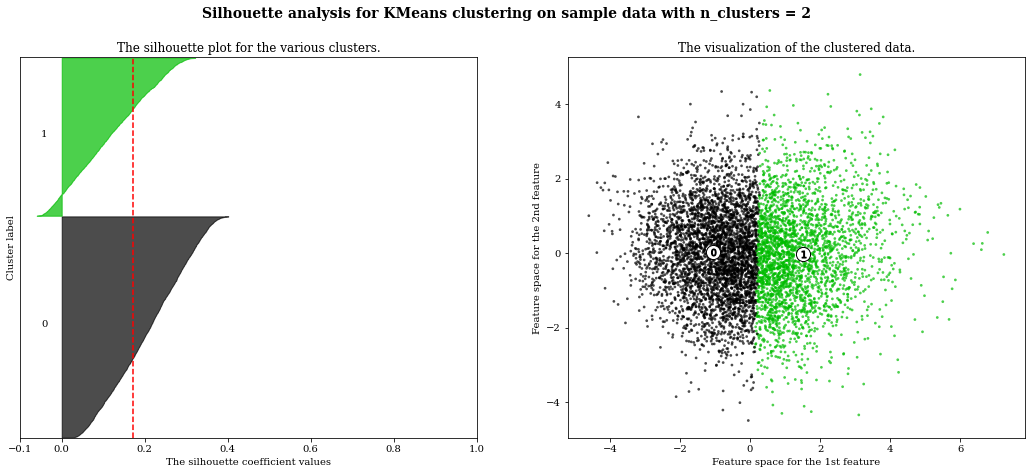

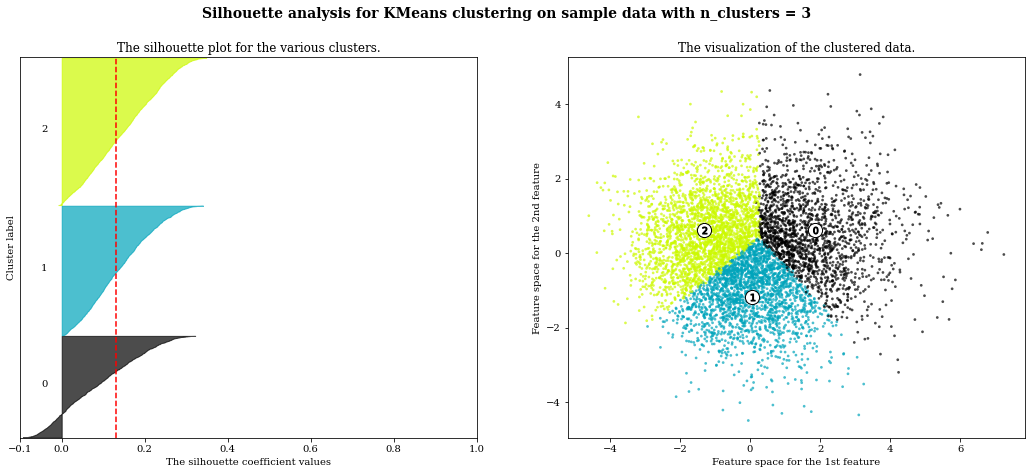

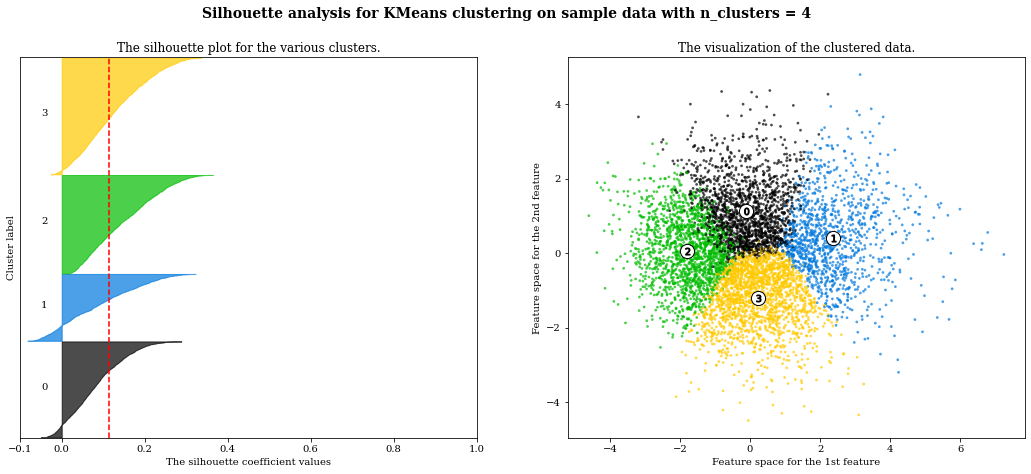

In [20]:
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig(ruta_imagenes+f'Silhouette_varios{n_clusters}.png', bbox_inches='tight', dpi=150)

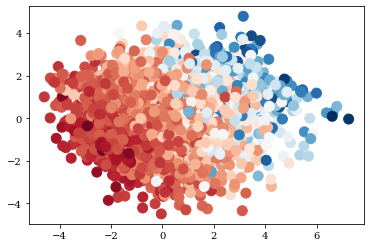

In [21]:
plt.scatter(X[:,0],X[:,1], c=y,s=100, cmap=cm.RdBu)

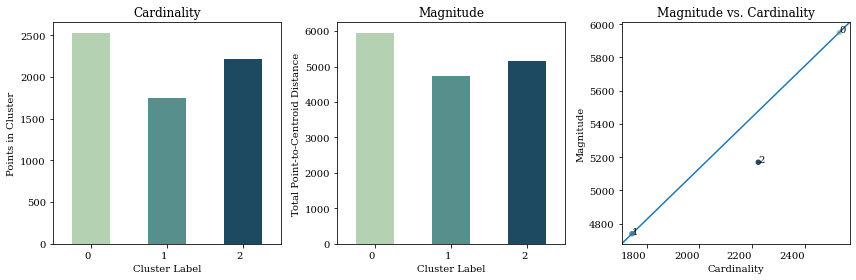

In [22]:
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean

# Let's define max. 6 different cluster colors - if you like you can add here more.
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

plot_cluster_cardinality(model.labels_,
                         ax=ax1,
                         title="Cardinality",
                         color=cluster_colors
                        )
plot_cluster_magnitude(X,
                       model.labels_,
                       model.cluster_centers_,
                       euclidean,
                       ax=ax2,
                       title="Magnitude",
                       color=cluster_colors
                      )
plot_magnitude_vs_cardinality(X,
                              model.labels_,
                              model.cluster_centers_,
                              euclidean,
                              color=cluster_colors[0:model.n_clusters],
                              ax=ax3, 
                              title="Magnitude vs. Cardinality")

fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()